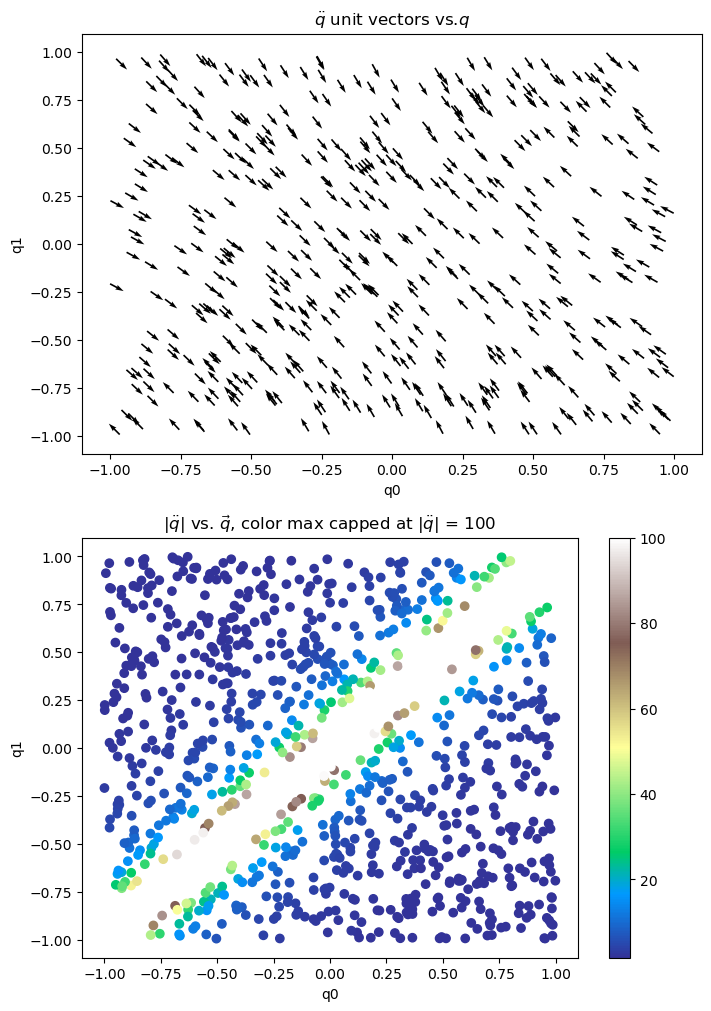

In [1319]:
##### import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, jacrev, vmap
import time
import torch
from torch import tensor, sum, log, max, exp

#####
# problem setup

m = torch.tensor([1],dtype=torch.float64)
k = torch.tensor([1],dtype=torch.float64)
alpha = torch.tensor([-1],dtype=torch.float64) #charge0*charge1

n_points = 1000
q0_min = -1
q0_max = 1
q1_min = -1
q1_max = 1
dist_threshold = 0.0
qdot_min = -1
qdot_max = 1

#####
# function definitions

def L(qv,qdotv,m,k,alpha): #including Coulomb potential
    return sum(0.5*m*qdotv**2) - sum(0.5*k*qv**2) - alpha*( 1/ (qv[0]-qv[1])**2 )**.5
    

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacrev(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacrev(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacrev(jacrev(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacrev(jacrev(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacrev(jacrev(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = torch.linalg.pinv(g_qdot_qdot2)
    #print(g_q_qdot2@QD.T)
    #print(D@(g_q2 - g_q_qdot2@QD.T).T)
    return (D@(g_q2 - g_q_qdot2@QD.T).T).reshape(Q.shape)

def QDD_true(Q,QD,m,k,alpha): #for testing if output is as expected for alpha=0
    QDD = -k/m*Q
    return QDD

QDDv = vmap(QDD,in_dims=(0,0,None,None,None))


q0_sampling = (q0_max - q0_min)*(torch.rand(n_points)) + q0_min
q1_sampling = (q1_max - q1_min)*(torch.rand(n_points)) + q1_min
qdot_sampling = (qdot_max - qdot_min)*(torch.rand([2,n_points])) + qdot_min

Q0 = q0_sampling
Q1 = q1_sampling
QD0 = qdot_sampling[0,:]
QD1 = qdot_sampling[1,:]

reject_Q = abs(Q0-Q1) >= dist_threshold

Q0 = Q0[reject_Q]
Q1 = Q1[reject_Q]
QD0 = QD0[reject_Q]
QD1 = QD1[reject_Q]

n_points = Q0.size()[0]

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)



Qv = torch.zeros(n_points,2)
Qv[:,0] = Q0
Qv[:,1] = Q1

QDv = torch.zeros(n_points,2)
QDv[:,0] = QD0
QDv[:,1] = QD1

out = QDDv(Qv,QDv,m,k,alpha)
outmag = (out[:,0]**2 + out[:,1]**2)**.5
#print(out)

#####
# plotting

quiver_points = 500 #define how many arrows to quiver plot
if quiver_points > n_points: #if specified value greater than number of points analyzed
    quiver_points = n_points #set quiver_points to n_points
fig,axs = plt.subplots(2,1,figsize=(8,12))
axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0]/outmag[:quiver_points],out[:quiver_points,1]/outmag[:quiver_points])
#axs[0].quiver(Qv[:quiver_points,0],Qv[:quiver_points,1],out[:quiver_points,0],out[:quiver_points,1])
axs[0].set_xlabel('q0')
axs[0].set_ylabel('q1')
axs[0].set_title(r'$\ddot{q}$ unit vectors vs.$q$')

cmax = 100
scatter = axs[1].scatter(Qv[:,0],Qv[:,1],c=np.min([outmag , cmax*torch.ones(n_points)],axis=0),cmap='terrain')
plt.colorbar(scatter,ax=axs[1])
axs[1].set_xlabel('q0')
axs[1].set_ylabel('q1')
axs[1].set_title(r'$|\ddot{q}|$ vs. $\vec{q}$, color max capped at $|\ddot{q}|$ = ' + f'{cmax}')


plt.show()

100%|██████████| 125/125 [00:02<00:00, 54.45it/s]


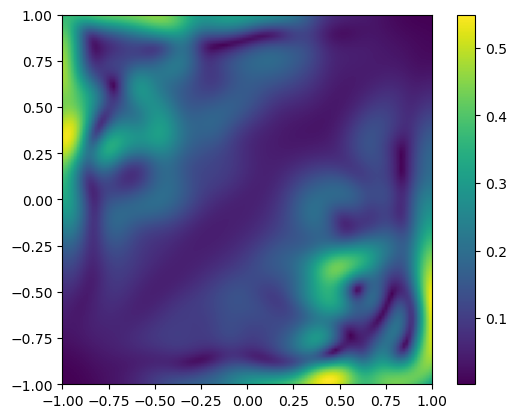

In [1323]:
n_div = 125

d_rad =0.015
d_fall = 0.152

q0_spacing = (q0_max-q0_min)/n_div
q1_spacing = (q1_max-q1_min)/n_div

mult1 = 2
mult = n_div*mult1

q0g = torch.linspace(q0_min,q0_max,n_div)
q1g = torch.linspace(q1_min,q1_max,n_div)

data0 = out[:,0]
data1 = out[:,1]

mv0 = torch.zeros(n_div,n_div)
mv1 = torch.zeros(n_div,n_div)
nmv0 = torch.zeros(n_div,n_div)
nmv1 = torch.zeros(n_div,n_div)
dmv0 = torch.zeros(n_div,n_div)
dmv1 = torch.zeros(n_div,n_div)
ndmv0 = torch.zeros(n_div,n_div)
ndmv1 = torch.zeros(n_div,n_div)
edmv0 = torch.zeros(n_div,n_div)
edmv1 = torch.zeros(n_div,n_div)
nedmv0 = torch.zeros(n_div,n_div)
nedmv1 = torch.zeros(n_div,n_div)
e1dmv0 = torch.zeros(n_div,n_div)
e1dmv1 = torch.zeros(n_div,n_div)
ne1dmv0 = torch.zeros(n_div,n_div)
ne1dmv1 = torch.zeros(n_div,n_div)

for i in tqdm.trange(n_div):
    for j in range(n_div):
        q0t = q0g[i]
        q1t = q1g[j]
        r0 = q0t - Qv[:,0]
        r1 = q1t - Qv[:,1]
        cond = (torch.abs( r0 )<q0_spacing*mult)*(torch.abs( r1 )<q1_spacing*mult)
        d0 = data0[cond]
        d1 = data1[cond]
        dn = torch.sqrt(d0**2 + d1**2)
        r0t = r0[cond]
        r1t = r1[cond]
        dist = torch.sqrt(r0t**2 + r1t**2)
        dm = torch.sqrt(d0**2 + d1**2)
        mv0[i,j] = torch.sum( d0 )
        mv1[i,j] = torch.sum( d1 )
        nmv0[i,j] = torch.sum( d0/dn )
        nmv1[i,j] = torch.sum( d1/dn )
        dmv0[i,j] = torch.sum( d0*r0t )
        dmv1[i,j] = torch.sum( d1*r1t )
        ndmv0[i,j] = torch.sum( r0t*d0/dn )
        ndmv1[i,j] = torch.sum( r1t*d1/dn )
        edmv0[i,j] = torch.sum( r0t*d0*exp( -(r0t**2 + r1t**2)/.005)  )
        edmv1[i,j] = torch.sum( r1t*d1*exp( -(r0t**2 + r1t**2)/.005)  )
        nedmv0[i,j] = torch.sum( r0t*d0*exp( -(r0t**2 + r1t**2)/.001)/dm**2  )
        nedmv1[i,j] = torch.sum( r1t*d1*exp( -(r0t**2 + r1t**2)/.001)/dm**2  )
        e1dmv0[i,j] = torch.sum( r0t*d0*exp( -((dist - d_rad)/d_fall)**2))  
        e1dmv1[i,j] = torch.sum( r1t*d1*exp( -((dist - d_rad)/d_fall)**2))  
        ne1dmv0[i,j] = torch.sum( r0t*d0*exp( -((dist - d_rad)/d_fall)**2)/dm**2  )
        ne1dmv1[i,j] = torch.sum( r1t*d1*exp( -((dist - d_rad)/d_fall)**2)/dm**2  )

#plt.imshow((nedmv0**2 + nedmv1**2)**.5,extent = [q0_min,q0_max,q1_min,q1_max],origin='lower')
plt.imshow((ne1dmv0**2 + ne1dmv1**2)**.5,extent = [q0_min,q0_max,q1_min,q1_max],origin='lower')
#plt.imshow((nedmv0**2 + nedmv1**2)**2,extent = [q0_min,q0_max,q1_min,q1_max],origin='lower')

plt.colorbar()




In [1284]:
outstore = out